Aqui importamos os módulos os e shutil, que são utilizados para manipular ficheiros e caminhos/diretórios.

Defenimos tamabém os caminhos das pastas, onde estão contidos os conjuntos/set's de treino, validação e teste.

In [23]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

Nao voltamos a repetir o erro dos modelos de feature extraction e defenimos logo o IMG_SIZE com tamanho de 150.

Criamos os conjuntos de dados de treino, validação e teste a partir dos respetivos diretórios. Assim, é especificado o caminho do diretório para cada um dos conjuntos anteriormente relatados.

O label_mode foi definido como categorical, tendo em conta que as labels são vetores one-hot encoded.

Posteriormente é definido o image_size, de forma a redimensionar todas as fotografias de input no respetivo conjunto, de forma a ter todas as fotografias do mesmo tamanho, sendo assim, se entrar na nossa rede uma fotografia 64x64, ela será redimensionada para o tamanho correto nesta fase.

Devido ao grande fluxo de imagens que compõem este projeto, e devido ao treino desta rede ser significativamente mais demorado e lento, decidimos dividir todos os dataset's, nomeadamente, validation e train em 6 dataset's distintos para cada conjunto, de forma a otimizar o tempo de treino da nossa rede. Apercebemo-nos que deveriavos dividir em mais partes pois no modelo ModelT_transferLearning_fineTuning_WithoutDataAumentation dividimos apenas em três partes e cada época demorava bastante tempo

In [24]:
from keras.utils import image_dataset_from_directory

IMG_SIZE = 150

train_dataset = image_dataset_from_directory(train_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))
validation_dataset = image_dataset_from_directory(validation_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))
test_dataset = image_dataset_from_directory(test_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))

#### Dividir o dataset ####
def get_dataset_size(dataset):
    return sum(1 for _ in dataset)

train_size = get_dataset_size(train_dataset)
validation_size = get_dataset_size(validation_dataset)

part_train_size = train_size // 6
part_validation_size = validation_size // 6

def split_dataset(dataset, part_size):
    parts = []
    for i in range(6):
        parts.append(dataset.skip(i * part_size).take(part_size))
    return parts

train_parts = split_dataset(train_dataset, part_train_size)
validation_parts = split_dataset(validation_dataset, part_validation_size)

train_dataset_1, train_dataset_2, train_dataset_3, train_dataset_4, train_dataset_5, train_dataset_6 = train_parts
validation_dataset_1, validation_dataset_2, validation_dataset_3, validation_dataset_4, validation_dataset_5, validation_dataset_6 = validation_parts

print(f"Train dataset parts sizes: {[get_dataset_size(part) for part in train_parts]}")
print(f"Validation dataset parts sizes: {[get_dataset_size(part) for part in validation_parts]}")


Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Train dataset parts sizes: [208, 208, 208, 208, 208, 208]
Validation dataset parts sizes: [52, 52, 52, 52, 52, 52]


O seguinte código serve para vizualizarmos algumas imagens dos subdatasets e támbem para validar que o código anterior realizou a divisão com sucesso

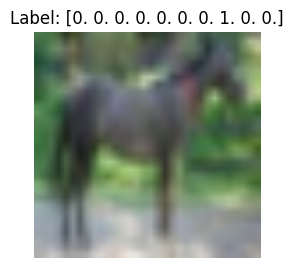

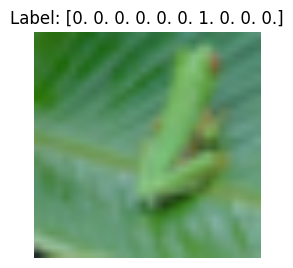

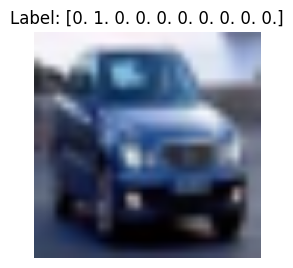

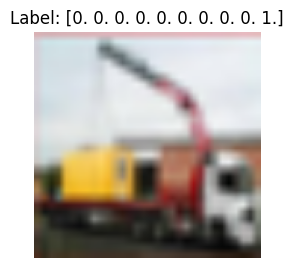

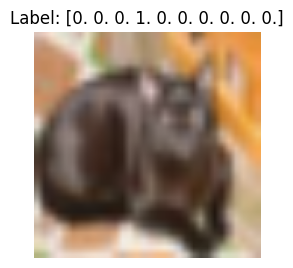

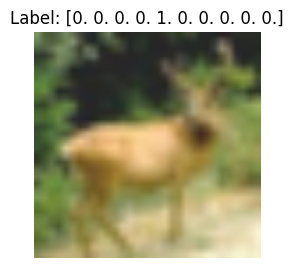

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_images(dataset, num_images=9):
    
    dataset_iter = iter(dataset)
    
    images, labels = next(dataset_iter)
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

# Exemplo de uso da funcao acima para visualizar uma imagem por cada um dos 6 datasets
visualize_images(train_dataset_1, num_images=1)
visualize_images(train_dataset_2, num_images=1)
visualize_images(train_dataset_3, num_images=1)
visualize_images(train_dataset_4, num_images=1)
visualize_images(train_dataset_5, num_images=1)
visualize_images(train_dataset_6, num_images=1)


O código importa a arquitetura da rede convolucional VGG19 pré-treinada através do módulo tensorflow.keras. A VGG19 é uma arquitetura de rede neural convolucional (CNN) renomada, conhecida por sua profundidade e eficácia em tarefas de reconhecimento de imagens. 

weights='imagenet', indica que os pesos da rede foram inicializados com os valores aprendidos a partir do conjunto de dados ImageNet. 

include_top=False, configura a VGG19 para não incluir a fully connected layer no topo da rede. Isto permite-nos que os recursos extraídos pela VGG19 sejam utilizados como entrada para camadas posteriormente defenidas por nós, adequadas para uma tarefa específica, neste caso iremos usar o modelo pré treinado no ficheiro ModelT_transferLearning_featureExtraction_WithoutDataAumentation_OnlyClassification.h5 para classificação. A razão pela qual decidimos utilizar a estrategia referida anteriormente é porque para realizar o fine tuning devemos seguir os seguintes passos:
1. Adicionar a nossa rede personalizada em cima de uma rede base já treinada
2. Congelar a rede base (vgg19)
3. Treinar a parte que adicionámos(rede personalizada)
4. Descongelar algumas camadas da rede base (vgg19)
5. Treinar os dois modelos em conjunto o que adicionámos(rede personalizada) e o modelo base(vgg19)

A razão pela qual realizamos esta estrategia é devido ao facto de podermos passar à frente os pontos 1, 2 e 3.

input_shape=(IMG_SIZE, IMG_SIZE, 3) especifica o formato esperado para as imagens de entrada na rede.

In [43]:
from keras.applications.vgg19 import VGG19

conv_base = VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)) 
conv_base.trainable = True

# Deixar todas as camadas, exceto as últimas cinco, não treináveis (congeladas)
for layer in conv_base.layers[:-5]: 
    layer.trainable = False

Verificar as camadas da vgg19, no output conseguimes observar que o block5 está todo defenido como Trainable=True, o que fará com que as camadas do respetivo bloco atualizem os seus pesos ao longo do treino

In [44]:
from tensorflow.keras.models import Model

# Função para imprimir o estado das camadas de forma recursiva
def print_layer_trainable_status(layer, indent=0):
    print(f"{' ' * indent}Layer: {layer.name}, Trainable: {layer.trainable}")
    if isinstance(layer, Model):
        for sub_layer in layer.layers:
            print_layer_trainable_status(sub_layer, indent + 2)

print_layer_trainable_status(conv_base)

Layer: vgg19, Trainable: True
  Layer: input_4, Trainable: False
  Layer: block1_conv1, Trainable: False
  Layer: block1_conv2, Trainable: False
  Layer: block1_pool, Trainable: False
  Layer: block2_conv1, Trainable: False
  Layer: block2_conv2, Trainable: False
  Layer: block2_pool, Trainable: False
  Layer: block3_conv1, Trainable: False
  Layer: block3_conv2, Trainable: False
  Layer: block3_conv3, Trainable: False
  Layer: block3_conv4, Trainable: False
  Layer: block3_pool, Trainable: False
  Layer: block4_conv1, Trainable: False
  Layer: block4_conv2, Trainable: False
  Layer: block4_conv3, Trainable: False
  Layer: block4_conv4, Trainable: False
  Layer: block4_pool, Trainable: False
  Layer: block5_conv1, Trainable: True
  Layer: block5_conv2, Trainable: True
  Layer: block5_conv3, Trainable: True
  Layer: block5_conv4, Trainable: True
  Layer: block5_pool, Trainable: True


Fazer import do modelo que irá ser usado para classificação, e ver a sua arquitetura

In [45]:
from tensorflow import keras

#Adicionar o modelo treinado com feature extraction
base_model = keras.models.load_model('models/ModelT_transferLearning_featureExtraction_WithoutDataAumentation_OnlyClassification.h5')

base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                           

No seguinte bloco de código é onde defenimos a layer para o data augmentation e fazemos a junção da mesma com os dois modelos, da CNN(Modelo usado para reconhecimento de imagens) e da NN(Modelo usado para classificação das imagens)

No data augmentation usamos as seguintes técnicas:

layers.RandomFlip("horizontal"): Inverte a imagem ao longo do eixo horizontal (esquerda para a direita).

layers.RandomRotation(0.1): Aplica uma rotação aleatória à imagem. O valor 0.1 indica uma rotação de até 10% do tamanho da imagem.

layers.RandomZoom(0.2): Aplica um zoom aleatório à imagem, aumentando ou diminuindo o tamanho da imagem até 20%.

layers.RandomContrast(0.2): Altera o contraste da imagem aleatoriamente, aumentando ou diminuindo a diferença entre as partes claras e escuras da imagem em até 20%.

GaussianNoise(stddev=0.1): Adiciona ruido gaussiano à imagem, isto ajuda o modelo a ser mais robusto a pequenas variações nos dados, imitando o ruído natural que pode estar presente nas imagens naturalmente em imagens do mundo real.

In [46]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GaussianNoise

# Definir a sequência de data augmentation
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        GaussianNoise(stddev=0.1),
    ]
)

# Criar uma camada de input com o mesmo shape da VGG19
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Aplicar data augmentation à camada de input
augmented_input = data_augmentation(input_layer)

# Passar a camada de data_augmentation como input para o modelo base VGG19
vgg19_output = conv_base(augmented_input)

# Passar a saída da VGG19 para o modelo pré-treinado
model_output = base_model(vgg19_output)

# Criar o novo modelo combinado com a VGG19 e o modelo pré-treinado
model = Model(inputs=input_layer, outputs=model_output)

Verificar a arquitetura do modelo completo

In [47]:
print_layer_trainable_status(model)

Layer: model_1, Trainable: True
  Layer: input_5, Trainable: True
  Layer: sequential_2, Trainable: True
    Layer: random_flip_2, Trainable: True
    Layer: random_rotation_2, Trainable: True
    Layer: random_zoom_2, Trainable: True
    Layer: random_contrast_2, Trainable: True
    Layer: gaussian_noise_2, Trainable: True
  Layer: vgg19, Trainable: True
    Layer: input_4, Trainable: False
    Layer: block1_conv1, Trainable: False
    Layer: block1_conv2, Trainable: False
    Layer: block1_pool, Trainable: False
    Layer: block2_conv1, Trainable: False
    Layer: block2_conv2, Trainable: False
    Layer: block2_pool, Trainable: False
    Layer: block3_conv1, Trainable: False
    Layer: block3_conv2, Trainable: False
    Layer: block3_conv3, Trainable: False
    Layer: block3_conv4, Trainable: False
    Layer: block3_pool, Trainable: False
    Layer: block4_conv1, Trainable: False
    Layer: block4_conv2, Trainable: False
    Layer: block4_conv3, Trainable: False
    Layer: block4_co

Os calbacks EarlyStopping, e ReduceLROnPlateau já foram explicados em notebooks anteriores.

Neste modelo temos uma novidade que é o ModelCheckpoint, esta técnica guarda o melhor modelo conseguido ao longo do processo de treino. No ModelCheckpoint defenimos os seguintes parâmetros:

filepath: Especificar o caminho do ficheiro de onde o modelo será guardado.

save_best_only=True: Garante que apenas o melhor modelo, baseado na métrica monitorada (neste caso a validation loss), seja salvo.

monitor='val_loss': Indica a metrica a ser monitorada

verbose=1: Ativa mensagens no output, indicando quando o modelo é salvo, ou não obteve melhorias

In [48]:
#A partir deste bloco iremos treinar o modelo para os sub datasets
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath='models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1 
)

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5, weight_decay=1e-1),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

Realização do primeiro treino com as layers do block5 defenidas como Trainable=True

In [49]:
#Subset 1
history = model.fit(train_dataset_1, epochs=10, validation_data=validation_dataset_1, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/10
208/208 [==============================] - ETA: 0s - loss: 1.3291 - accuracy: 0.6418
Epoch 1: val_loss improved from inf to 0.66434, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 781s 4s/step - loss: 1.3291 - accuracy: 0.6418 - val_loss: 0.6643 - val_accuracy: 0.8209 - lr: 1.0000e-05
Epoch 2/10
208/208 [==============================] - ETA: 0s - loss: 1.0239 - accuracy: 0.7197
Epoch 2: val_loss improved from 0.66434 to 0.57426, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5
208/208 [==============================] - 762s 4s/step - loss: 1.0239 - accuracy: 0.7197 - val_loss: 0.5743 - val_accuracy: 0.8341 - lr: 1.0000e-05
Epoch 3/10
208/208 [==============================] - ETA: 0s - loss: 0.9070 - accuracy: 0.7437
Epoch 3: val_loss improved from 0.57426 to 0.53203, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5
208/208 [==============================] - 769s 4s/step - loss: 0.9070 - accuracy: 0.7437 - val_loss: 0.5320 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 4/10
208/208 [==============================] - ETA: 0s - loss: 0.8073 - accura

Fazer mais um treino agora com o subset dois, no treino anterior o Early Stopping baixou o lerning rate para 1e-7, iremos colocar o novo lerning rate a 1e-7 com um minimo possivel de 1e-8

In [50]:
#Subset 2
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-7, weight_decay=1e-1),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-8)

history = model.fit(train_dataset_2, epochs=5, validation_data=validation_dataset_2, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.8320 - accuracy: 0.7725
Epoch 1: val_loss did not improve from 0.45966
208/208 [==============================] - 774s 4s/step - loss: 0.8320 - accuracy: 0.7725 - val_loss: 0.4775 - val_accuracy: 0.8624 - lr: 1.0000e-07
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.7629
Epoch 2: val_loss did not improve from 0.45966
208/208 [==============================] - 768s 4s/step - loss: 0.8308 - accuracy: 0.7629 - val_loss: 0.4866 - val_accuracy: 0.8648 - lr: 1.0000e-07
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.8281 - accuracy: 0.7656
Epoch 3: val_loss did not improve from 0.45966
208/208 [==============================] - 770s 4s/step - loss: 0.8281 - accuracy: 0.7656 - val_loss: 0.4758 - val_accuracy: 0.8624 - lr: 2.0000e-08
Epoch 4/5
208/208 [==============================] - ETA: 0s - loss: 0.8399 - accuracy: 0.7584
Epoch 4: val_loss did not improv

O treino acima teve uma resposta praticamente igual, vamos aumentar o lerning rate (mais à frente reparamos que o devia-mos ter diminuido o lerning rate com a ajuda do ReduceLROnPlateau)

In [51]:
#Subset 3
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5, weight_decay=1e-1),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

history = model.fit(train_dataset_3, epochs=5, validation_data=validation_dataset_3, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.8383 - accuracy: 0.7620
Epoch 1: val_loss improved from 0.45966 to 0.45856, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 772s 4s/step - loss: 0.8383 - accuracy: 0.7620 - val_loss: 0.4586 - val_accuracy: 0.8648 - lr: 1.0000e-05
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.7733
Epoch 2: val_loss improved from 0.45856 to 0.44348, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5
208/208 [==============================] - 766s 4s/step - loss: 0.7557 - accuracy: 0.7733 - val_loss: 0.4435 - val_accuracy: 0.8666 - lr: 1.0000e-05
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.7901
Epoch 3: val_loss did not improve from 0.44348
208/208 [==============================] - 769s 4s/step - loss: 0.6888 - accuracy: 0.7901 - val_loss: 0.4573 - val_accuracy: 0.8648 - lr: 1.0000e-05
Epoch 4/5
208/208 [==============================] - ETA: 0s - loss: 0.6338 - accuracy: 0.8071
Epoch 4: val_loss improved from 0.44348 to 0.40545, saving model to models/ModelT_t

O modelo não está a conseguir convergir, vamos colocar o block4 da vgg19 como Trainable=True

In [53]:
for layer in conv_base.layers[-10:]:
    layer.trainable = True

Verificar a arquitetura do modelo completo

In [54]:
print_layer_trainable_status(model)

Layer: model_1, Trainable: True
  Layer: input_5, Trainable: True
  Layer: sequential_2, Trainable: True
    Layer: random_flip_2, Trainable: True
    Layer: random_rotation_2, Trainable: True
    Layer: random_zoom_2, Trainable: True
    Layer: random_contrast_2, Trainable: True
    Layer: gaussian_noise_2, Trainable: True
  Layer: vgg19, Trainable: True
    Layer: input_4, Trainable: False
    Layer: block1_conv1, Trainable: False
    Layer: block1_conv2, Trainable: False
    Layer: block1_pool, Trainable: False
    Layer: block2_conv1, Trainable: False
    Layer: block2_conv2, Trainable: False
    Layer: block2_pool, Trainable: False
    Layer: block3_conv1, Trainable: False
    Layer: block3_conv2, Trainable: False
    Layer: block3_conv3, Trainable: False
    Layer: block3_conv4, Trainable: False
    Layer: block3_pool, Trainable: False
    Layer: block4_conv1, Trainable: True
    Layer: block4_conv2, Trainable: True
    Layer: block4_conv3, Trainable: True
    Layer: block4_conv4

Realização do primeiro treino com as layers do block5 e block4 defenidas como Trainable=True

In [55]:
#Subset 3
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=1e-2),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-8)

history = model.fit(train_dataset_3, epochs=4, validation_data=validation_dataset_3, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/4
208/208 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.8191
Epoch 1: val_loss improved from 0.40545 to 0.38988, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 1121s 5s/step - loss: 0.5720 - accuracy: 0.8191 - val_loss: 0.3899 - val_accuracy: 0.8804 - lr: 1.0000e-06
Epoch 2/4
208/208 [==============================] - ETA: 0s - loss: 0.5805 - accuracy: 0.8179
Epoch 2: val_loss did not improve from 0.38988
208/208 [==============================] - 1071s 5s/step - loss: 0.5805 - accuracy: 0.8179 - val_loss: 0.3962 - val_accuracy: 0.8810 - lr: 1.0000e-06
Epoch 3/4
208/208 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.8233
Epoch 3: val_loss improved from 0.38988 to 0.37245, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5
208/208 [==============================] - 1108s 5s/step - loss: 0.5727 - accuracy: 0.8233 - val_loss: 0.3724 - val_accuracy: 0.8852 - lr: 2.0000e-07
Epoch 4/4
208/208 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.8263
Epoch 4: val_loss did not improve from 0.37245
208/208 [========================

In [56]:
#Subset 4
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5, weight_decay=1e-1),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-8)

history = model.fit(train_dataset_4, epochs=5, validation_data=validation_dataset_4, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.7715
Epoch 1: val_loss did not improve from 0.37245
208/208 [==============================] - 1138s 5s/step - loss: 0.7783 - accuracy: 0.7715 - val_loss: 0.4236 - val_accuracy: 0.8696 - lr: 1.0000e-05
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.8099
Epoch 2: val_loss did not improve from 0.37245
208/208 [==============================] - 1116s 5s/step - loss: 0.6404 - accuracy: 0.8099 - val_loss: 0.4428 - val_accuracy: 0.8678 - lr: 1.0000e-05
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.8214
Epoch 3: val_loss did not improve from 0.37245
208/208 [==============================] - 1116s 5s/step - loss: 0.5610 - accuracy: 0.8214 - val_loss: 0.3854 - val_accuracy: 0.8870 - lr: 2.0000e-06
Epoch 4/5
208/208 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.8287
Epoch 4: val_loss improved fr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 1113s 5s/step - loss: 0.5279 - accuracy: 0.8287 - val_loss: 0.3598 - val_accuracy: 0.8972 - lr: 2.0000e-06
Epoch 5/5
208/208 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.8383
Epoch 5: val_loss improved from 0.35984 to 0.35328, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5
208/208 [==============================] - 1119s 5s/step - loss: 0.5107 - accuracy: 0.8383 - val_loss: 0.3533 - val_accuracy: 0.8978 - lr: 2.0000e-06


In [57]:
#Subset 5
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=1e-2),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-8)

history = model.fit(train_dataset_5, epochs=5, validation_data=validation_dataset_5, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.8172
Epoch 1: val_loss did not improve from 0.35328
208/208 [==============================] - 1122s 5s/step - loss: 0.6085 - accuracy: 0.8172 - val_loss: 0.3741 - val_accuracy: 0.8816 - lr: 1.0000e-06
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.5953 - accuracy: 0.8184
Epoch 2: val_loss did not improve from 0.35328
208/208 [==============================] - 1124s 5s/step - loss: 0.5953 - accuracy: 0.8184 - val_loss: 0.3801 - val_accuracy: 0.8840 - lr: 1.0000e-06
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.8185
Epoch 3: val_loss did not improve from 0.35328
208/208 [==============================] - 1121s 5s/step - loss: 0.5914 - accuracy: 0.8185 - val_loss: 0.3688 - val_accuracy: 0.8876 - lr: 2.0000e-07
Epoch 4/5
208/208 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.8202
Epoch 4: val_loss improved fr

Conseguimos ver que o checkpoint callback guardou um modelo que agora é o melhor com val_acc 90%

In [58]:
#Subset 6
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-7, weight_decay=1e-2),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-9)

history = model.fit(train_dataset_6, epochs=5, validation_data=validation_dataset_6, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.8196
Epoch 1: val_loss improved from 0.35326 to 0.34306, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5
208/208 [==============================] - 1104s 5s/step - loss: 0.6143 - accuracy: 0.8196 - val_loss: 0.3431 - val_accuracy: 0.8954 - lr: 1.0000e-07
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.8181
Epoch 2: val_loss improved from 0.34306 to 0.32948, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5
208/208 [==============================] - 1102s 5s/step - loss: 0.6131 - accuracy: 0.8181 - val_loss: 0.3295 - val_accuracy: 0.8966 - lr: 1.0000e-07
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.8190
Epoch 3: val_loss did not improve from 0.32948
208/208 [==============================] - 1101s 5s/step - loss: 0.6235 - accuracy: 0.8190 -

O ReduceLROnPlateau está a diminuir o lerning rate para 1e-8, vamos colocar então esse valor e fazer mais um treino

In [59]:
#Subset 3
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-8, weight_decay=1e-2),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-10)

history = model.fit(train_dataset_3, epochs=5, validation_data=validation_dataset_3, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.5167 - accuracy: 0.8373
Epoch 1: val_loss improved from 0.31612 to 0.29887, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


208/208 [==============================] - 1130s 5s/step - loss: 0.5167 - accuracy: 0.8373 - val_loss: 0.2989 - val_accuracy: 0.9002 - lr: 1.0000e-08
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.8379
Epoch 2: val_loss improved from 0.29887 to 0.29744, saving model to models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5
208/208 [==============================] - 1121s 5s/step - loss: 0.5215 - accuracy: 0.8379 - val_loss: 0.2974 - val_accuracy: 0.9002 - lr: 1.0000e-08
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.8367
Epoch 3: val_loss did not improve from 0.29744
208/208 [==============================] - 1122s 5s/step - loss: 0.5184 - accuracy: 0.8367 - val_loss: 0.3139 - val_accuracy: 0.8972 - lr: 1.0000e-08
Epoch 4/5
208/208 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.8475
Epoch 4: val_loss improved from 0.29744 to 0.28645, saving model to models/Model

O accuracy aumentou e o validation accuracy manteve-se igual, ou seja o modelo está a ficar com overfitting, iremos fazer mais dois treino só para ver a resposta do modelo se não obtivermos melhores resultados iremos descongelar mais um block da vgg19.

Baixar ainda mais o lerning rate pois o ReduceLROnPlateau está a cada treino a baixá-lo

In [60]:
#Subset 1
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-9, weight_decay=1e-2),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-10)

history = model.fit(train_dataset_1, epochs=5, validation_data=validation_dataset_1, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.8415
Epoch 1: val_loss did not improve from 0.28645
208/208 [==============================] - 1121s 5s/step - loss: 0.5029 - accuracy: 0.8415 - val_loss: 0.3268 - val_accuracy: 0.9020 - lr: 1.0000e-09
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.8430
Epoch 2: val_loss did not improve from 0.28645
208/208 [==============================] - 1120s 5s/step - loss: 0.5045 - accuracy: 0.8430 - val_loss: 0.3226 - val_accuracy: 0.9008 - lr: 1.0000e-09
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.8428
Epoch 3: val_loss did not improve from 0.28645
208/208 [==============================] - 1119s 5s/step - loss: 0.5066 - accuracy: 0.8428 - val_loss: 0.3436 - val_accuracy: 0.8996 - lr: 1.0000e-09
Epoch 4/5
208/208 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.8343
Epoch 4: val_loss did not imp

Iremos colocar o lerning rate a 1e-10, pois o ReduceLROnPlateau está a diminuir ainda mais o lerning rate, sendo assim iremos usar o valor que ele está propor

In [61]:
#Subset 2
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-10, weight_decay=1e-2),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-12)

history = model.fit(train_dataset_2, epochs=5, validation_data=validation_dataset_2, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.8211
Epoch 1: val_loss did not improve from 0.28645
208/208 [==============================] - 1228s 6s/step - loss: 0.5927 - accuracy: 0.8211 - val_loss: 0.3338 - val_accuracy: 0.8990 - lr: 1.0000e-10
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.8164
Epoch 2: val_loss did not improve from 0.28645
208/208 [==============================] - 1202s 6s/step - loss: 0.6185 - accuracy: 0.8164 - val_loss: 0.3306 - val_accuracy: 0.9002 - lr: 1.0000e-10
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.8146
Epoch 3: val_loss did not improve from 0.28645
208/208 [==============================] - 1268s 6s/step - loss: 0.6178 - accuracy: 0.8146 - val_loss: 0.3415 - val_accuracy: 0.8960 - lr: 1.0000e-10
Epoch 4/5
208/208 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.8197
Epoch 4: val_loss did not imp

Verificar os resultados em forma de gráficos

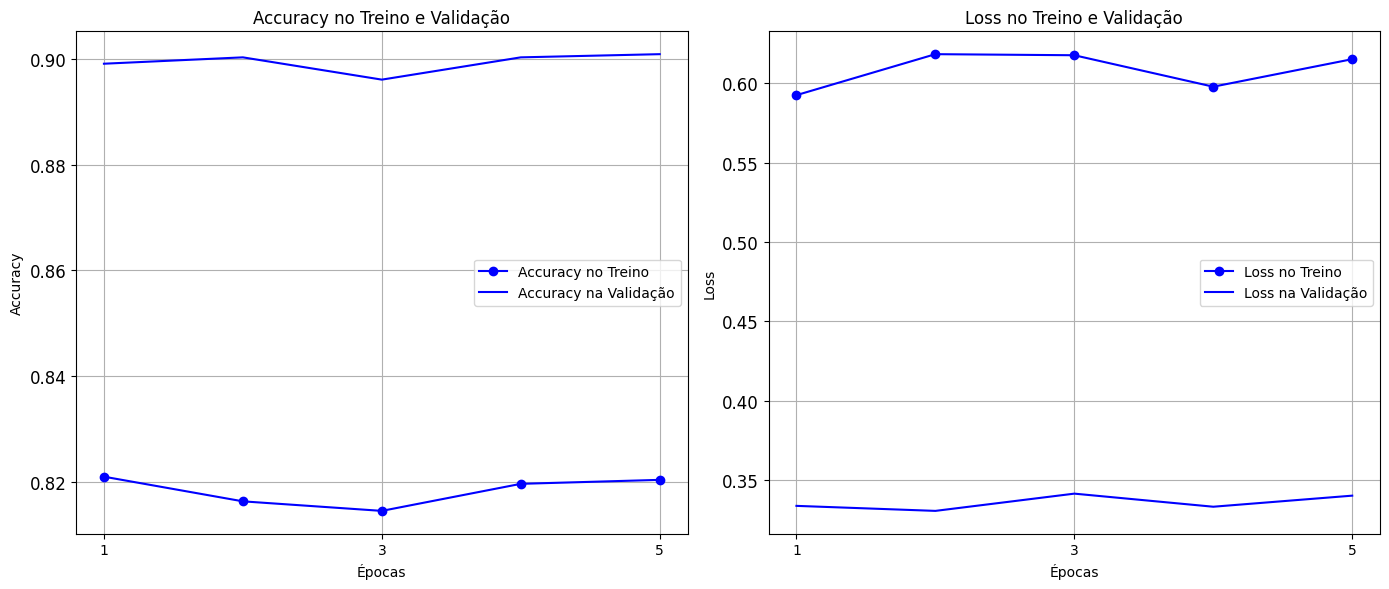

In [62]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Gráfico da Accuracya
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Accuracy no Treino')
plt.plot(epochs, val_acc, 'b-', label='Accuracy na Validação')
plt.title('Accuracy no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) 
plt.xticks(range(1, len(acc) + 1, 2))  
plt.yticks(fontsize=12) 
plt.tight_layout()

# Gráfico da Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Loss no Treino')
plt.plot(epochs, val_loss, 'b-', label='Loss na Validação')
plt.title('Loss no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 
plt.xticks(range(1, len(acc) + 1, 2))
plt.yticks(fontsize=12) 
plt.tight_layout()

# Mostrar os gráficos
plt.show()

Descongelar o block 3 para verificar se obtemos melhorias

In [63]:
for layer in conv_base.layers[-15:]:
    layer.trainable = True

Verificar a arquitetura do modelo, ver se as camadas do block 3 ficaram como Trainable=True

In [64]:
print_layer_trainable_status(model)

Layer: model_1, Trainable: True
  Layer: input_5, Trainable: True
  Layer: sequential_2, Trainable: True
    Layer: random_flip_2, Trainable: True
    Layer: random_rotation_2, Trainable: True
    Layer: random_zoom_2, Trainable: True
    Layer: random_contrast_2, Trainable: True
    Layer: gaussian_noise_2, Trainable: True
  Layer: vgg19, Trainable: True
    Layer: input_4, Trainable: False
    Layer: block1_conv1, Trainable: False
    Layer: block1_conv2, Trainable: False
    Layer: block1_pool, Trainable: False
    Layer: block2_conv1, Trainable: False
    Layer: block2_conv2, Trainable: False
    Layer: block2_pool, Trainable: False
    Layer: block3_conv1, Trainable: True
    Layer: block3_conv2, Trainable: True
    Layer: block3_conv3, Trainable: True
    Layer: block3_conv4, Trainable: True
    Layer: block3_pool, Trainable: True
    Layer: block4_conv1, Trainable: True
    Layer: block4_conv2, Trainable: True
    Layer: block4_conv3, Trainable: True
    Layer: block4_conv4, Tra

Realizar testes para ver se a operação anterior irá ajudar o modelo a obter melhores resultados

In [65]:
#Subset 2
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-11, weight_decay=1e-2),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-12)

history = model.fit(train_dataset_2, epochs=5, validation_data=validation_dataset_2, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/5
208/208 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.8143
Epoch 1: val_loss did not improve from 0.28645
208/208 [==============================] - 1509s 7s/step - loss: 0.6051 - accuracy: 0.8143 - val_loss: 0.3361 - val_accuracy: 0.8978 - lr: 1.0000e-11
Epoch 2/5
208/208 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.8199
Epoch 2: val_loss did not improve from 0.28645
208/208 [==============================] - 1649s 8s/step - loss: 0.6090 - accuracy: 0.8199 - val_loss: 0.3455 - val_accuracy: 0.8990 - lr: 1.0000e-11
Epoch 3/5
208/208 [==============================] - ETA: 0s - loss: 0.5990 - accuracy: 0.8190
Epoch 3: val_loss did not improve from 0.28645
208/208 [==============================] - 1665s 8s/step - loss: 0.5990 - accuracy: 0.8190 - val_loss: 0.3233 - val_accuracy: 0.9038 - lr: 2.0000e-12
Epoch 4/5
208/208 [==============================] - ETA: 0s - loss: 0.5992 - accuracy: 0.8190
Epoch 4: val_loss did not imp

Realizar mais um teste agora com o subdataset 

In [66]:
#Subset 4
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-12, weight_decay=1e-2),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-14)

history = model.fit(train_dataset_4, epochs=3, validation_data=validation_dataset_4, batch_size=128, callbacks=[checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/3
208/208 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.8439
Epoch 1: val_loss did not improve from 0.28645
208/208 [==============================] - 1506s 7s/step - loss: 0.5064 - accuracy: 0.8439 - val_loss: 0.3214 - val_accuracy: 0.9008 - lr: 1.0000e-12
Epoch 2/3
208/208 [==============================] - ETA: 0s - loss: 0.4873 - accuracy: 0.8416
Epoch 2: val_loss did not improve from 0.28645
208/208 [==============================] - 1516s 7s/step - loss: 0.4873 - accuracy: 0.8416 - val_loss: 0.3384 - val_accuracy: 0.8930 - lr: 1.0000e-12
Epoch 3/3
208/208 [==============================] - ETA: 0s - loss: 0.4849 - accuracy: 0.8481
Epoch 3: val_loss did not improve from 0.28645
208/208 [==============================] - 1527s 7s/step - loss: 0.4849 - accuracy: 0.8481 - val_loss: 0.3441 - val_accuracy: 0.8906 - lr: 2.0000e-13


Verificamos que ao descongelar as camadas do block 3 o modelo não obteve melhores resultados, na verdade até começou a dar sinais de overfitting 

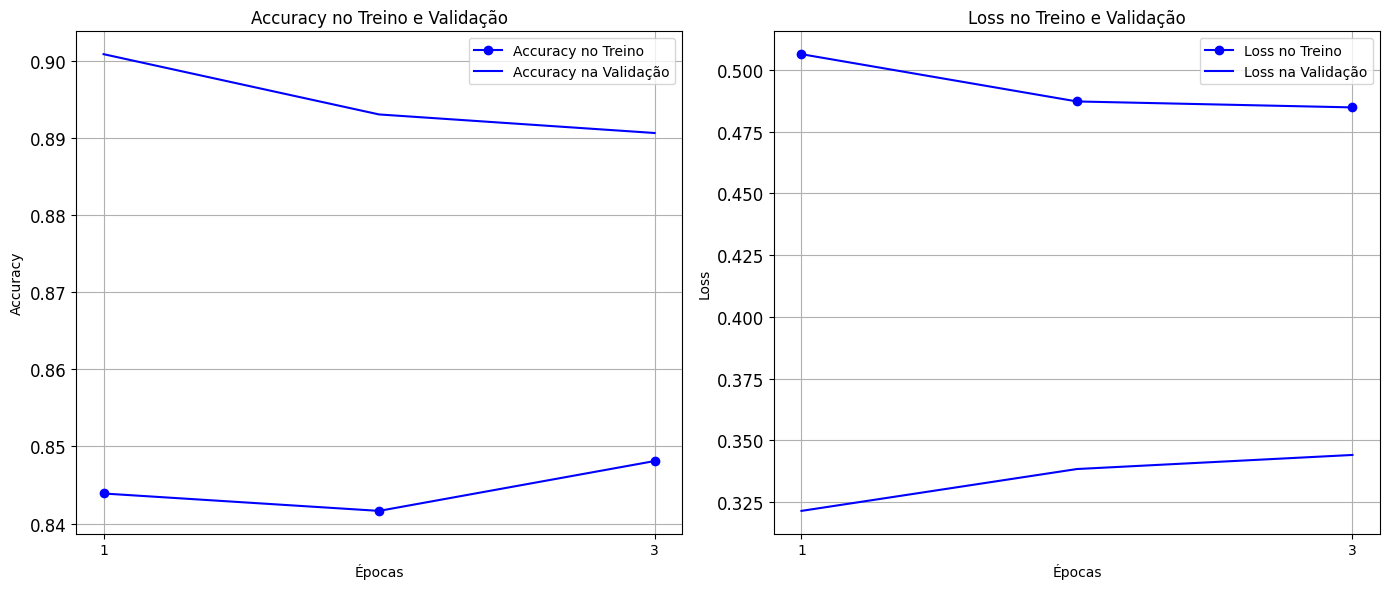

In [67]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Gráfico da Accuracya
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Accuracy no Treino')
plt.plot(epochs, val_acc, 'b-', label='Accuracy na Validação')
plt.title('Accuracy no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True) 
plt.xticks(range(1, len(acc) + 1, 2))  
plt.yticks(fontsize=12) 
plt.tight_layout()

# Gráfico da Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Loss no Treino')
plt.plot(epochs, val_loss, 'b-', label='Loss na Validação')
plt.title('Loss no Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 
plt.xticks(range(1, len(acc) + 1, 2))
plt.yticks(fontsize=12) 
plt.tight_layout()

# Mostrar os gráficos
plt.show()

Realização do deste final ao modelo com o dataset de test

In [68]:
from tensorflow import keras

loaded_model = keras.models.load_model('models/ModelT_transferLearning_fineTuning_WithDataAumentation_best.h5')

val_loss, val_acc = loaded_model.evaluate(test_dataset) 
print('val_acc:', val_acc)

313/313 [==============================] - 808s 3s/step - loss: 0.3491 - accuracy: 0.8910
val_acc: 0.890999972820282


Como principal extra do nosso projeto, para além do optimizer utilizado, tipos de data augmentation utilizados e outras funções que vão para além das utilizadas nas aulas, decidimos desenvolver um website que utiliza os modelos dos nossos notebook's. Assim, foi necessário utilizar o tensorflowjs_converter, que é uma biblioteca python, que permite converter o modelo de formato h5 para json, de forma a ser possível implementar a utilização do respetivo modelo no website. Posteriormente a este passo, e após termos o modelo em json, implementámos o código via JavaScript que faz a interligação entre o website e o modelo. O código JavaScript está disponível no ficheiro da diretoria ./web/main.js.

Para utilizar o nosso website, visto que não está publicado na web, é necessário instalar o VSCode e a respetiva extensão de live server, e correr o ficheiro index.html na diretoria ./web/index.html. A interação com a app web é simples, selecionar o tipo de modelo a ser utilizado, selecionar uma fotografia e realizar a operação de predict chamando o nosso modelo, por sua vez em json. Por fim, será apresentada uma label com a predicted class e também um gráfico de API Alphabet Google com as probabilidades para cada classe da nossa rede. O nosso website, permite também alternar entre tema claro e escuro, conforme a preferência do utilizador.

Infelizmente, devido a uma incompatibilidade entre o tensorflowjs e a rede VGG19, não foi possível implementar este modelo na versão web.

Assim, apresentamos um exemplo da interface web que podem esperar:

![GUI do website](../img/GUI.png "GUI do website")


Para gerir e trabalhar em grupo neste projeto, foi utilizado o software GitHub. O nosso repositório GitHub cumpre com toda a organização e logística que são essênciais para um projeto na nossa área. 

Explicação dos objetivos de cada pasta do nosso Repositório (Para respetiva consulta de informação):
##### Pasta DOC: Contém o enunciado do projeto
##### Pasta WEB: Contém o Website desenvolvido relatado anteriormente
##### Pastas TEST, VALIDATION e TRAIN: Contém os dataset's de teste, validação e treino, respetivamente, da nossa rede
##### Pasta NOTEBOOKS: Contém os nossos notebook's com output e comentários, bem como as suas versões clean e os modelos gerados pelo treino da rede bem como a conversão para JSON
##### Pasta RESULTS: Contém os resultados dos treinos das nossas redes (Importante a sua consulta)
##### Pasta IMG: Contém imagens auxiliáres
##### Ficheiro README: Contém a apresentação do projeto e a distinção das pastas de treino/validação (dataset's)

Para consulta deixamos o seguinte link (carregar em cima da fotografia do ícone do GitHub):

[![GitHub](../img/github-logo.png)](https://github.com/goncaloferreira966/Projeto_IA)]

### Powered By:
##### Gonçalo Ferreira, nº 2222051
##### José Delgado, nº 2222049